# I'm a polygon: get me out of here!
## Using GeoPandas to count nearby bus stops
### Matthew Silverman, Data Scientist, Bays Consulting

## Introduction
At Bays Consulting, one of our current passions lies in delivering insight for local areas in the UK.  As a data scientist, I am in my comfort zone when working with data that describes abstract entities, like financial transactions or computer network events.  At a basic level, analysis and profiling of such data generally relies on simple, exact keys for joining and aggregation.  But to explore deeper what's happening in a local community, we need to expand our set of available tools and get to grips with geospatial analysis; that is, analysis of data that includes points, lines and polygons in space.

In this blog I am going take a short dive into some geospatial analysis, by asking the question of how many bus stops can be reached easily from a local area.  I'll making particular use of the [``geopandas``](https://geopandas.org/index.html) library.

## Where to get the data?
I'm going to use two publicly available data sets in today's blog.

Firstly, to profile small localities, I'm going to work at the level of Lower Layer Super Output Areas (LSOAs).  These are a common unit of statistical geography here in the UK, aiming to encompass about 1,500 people.  It's handy to work with these when building up a profile of a local area, as there is a good supply of up-to-date open socio-economic data despite the relatively local size.  I've taken boundary data for the LSOAs in a portion of North Yorkshire from the ONS's [Open Geography Portal](https://geoportal.statistics.gov.uk/search?collection=Dataset&sort=name&tags=all(BDY_LSOA)).

Secondly, to count up accessibility of public transport access points, the Department for Transport in the UK helpfully publishes a comprehensive, standardised gazetteer of all transport stops, known as [NaPTAN](https://naptan.app.dft.gov.uk/DataRequest/help).

## Bringing the data in
To run these examples in Python 3, you will need to install the packages below.

In [1]:
import requests      # for internet downloads
import urllib        # URL manipulation
import pandas as pd  # standard dataset manipulation
import geopandas     # pandas extension for working with spatial datasets
import descartes     # needed for making the figures
import shapely       # base geometry
import matplotlib    # plotting

Now I'll construct a query to the Geoportal to download the LSOAs in my area of interest, as JSON, and pop them into a ``GeoDataFrame``.  I'll explain the signifiance of some of the code in comments.  You'll notice we're working in latitude and longitude, also known as [EPSG:4326](http://epsg.io/4326); more on this later!

In [2]:
# the base URL
base_url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/lsoa/FeatureServer/0/query"  

# a rectangular slice of North Yorks
bounds = [-1.26, 53.82, 0.00, 54.39] 

params = {
    'outFields': ','.join(("LSOA11CD", "LSOA11NM")),  # choose to keep LSOA code and name in the results 
    'geometryType': "esriGeometryEnvelope",           # our area of interest is a rectange
    'spatialRel': "esriSpatialRelIntersects",         # get all data intersecting our rectangle
    'geometry': ','.join(str(b) for b in bounds),     # send the bounding rectangle as a comma-delimited string
    'inSR': 4326, 'outSR': 4326,                      # use good old latitude/longitude as the coordinates
    'f': "json",                                      # JSON please, something GeoPandas can work with
    'resultType': 'standard',                         # download all results, rather than paginating
}

url = base_url + '?' + urllib.parse.urlencode(params)  # combine our parameters into a query string
areas = geopandas.read_file(url).set_index('LSOA11CD') # download and parse using GeoPandas, use LSOA code as index

Now we need the bus stops from NaPTAN.  The full dataset is rather large, but we can save some time by only requesting data for  North Yorkshire and the East Riding; these areas are coded as ``320`` and ``370`` in the [National Public Transport Gazetteer](https://www.gov.uk/government/publications/national-public-transport-gazetteer); in addition, the city of York is labelled separately as ``329``.  The data comes as a zipped set of CSVs; we're just interested in the stop locations today.  Unhelpfully, the CSV files are nested inside a second zip file for each region, but the Python code given here can nevertheless dig them out.

In [3]:
# libraries to work with zip friles
from io import BytesIO
from zipfile import ZipFile

# the North Yorks dataset
url = "https://naptan.app.dft.gov.uk/DataRequest/Naptan.ashx?format=csv&LA=220|320|329"  # high-level areas of interest

stops = []

with requests.get(url) as r:
    with ZipFile(BytesIO(r.content)) as z1:
        for f in z1.filelist:                      # list the contents of top level zip file
            if f.filename.endswith(".zip"):       # find all nested zip files
                with z1.open(f.filename) as f1:   # open the nested zip file for reading
                    with ZipFile(f1) as z2: 
                        with z2.open("Stops.csv") as f2:  # open the csv for reading
                            # use pandas to read the csv data, keeping certain columns of interest
                            stops.append(pd.read_csv(f2, 
                                                     usecols=['ATCOCode','CommonName', 'Latitude', 'Longitude'], 
                                                     index_col='ATCOCode',
                                                     encoding='iso-8859-1'))  # the string data is encoded in a particular way
                            
stops = pd.concat(stops)  # combine the list of data frames into one big data frame

Let's have a quick look at that data.  The good news is that the stop is named and geolocated in latitude/longitude co-ordinates, but we need to do a little more processing to get the data into GeoPandas for spatial analysis.

In [4]:
stops.head(3)

,CommonName,Longitude,Latitude
ATCOCode,,,
2200YEA00079,Beverley Lairgate,-0.430858,53.839716
2200YEA00067,Beverley Swinemoor Lane,-0.409905,53.846380
2200YEZ01389,Cowden Lane End,-0.134892,53.865639


To convert the plain pandas ``DataFrame`` into a ``GeoDataFrame``, we apply a function to each row of the data, combining the latitude and longitude into a ``Point`` object.  We can use the resulting sets of points as the ``geometry`` of our new data frame.  Finally, to constrain today's analysis a bit, we can use the [``clip``](https://geopandas.org/reference/geopandas.clip.html) utility to subset our stops to the total bounding rectanle of our areas of interest.

Note that the ``Point`` constructor takes its arguments in the order `x` i.e. east/west followed by `y`, so we must pass in longitude and then latitude; usually latitude and longitude are quoted in the reverse order!

In [5]:
from shapely.geometry import Point, box
points = stops.apply(lambda x: Point(x.Longitude, x.Latitude), axis='columns')
stops = geopandas.GeoDataFrame(stops, geometry=points, crs='EPSG:4326')  # convert to GeoDataFrame, marking that lat/longs are used
stops = geopandas.clip(stops, box(*areas.total_bounds))  # form a bounding rectangle from the areas, and clip the stop data

Let's summarise what we've done so far.  We have created two geometric-aware data frames:
* ``areas``: names and polygons of local areas (LSOAs)
* ``stops``: point locations of public transport access points i.e. bus stops.

We can use the built-in geopandas plotting utilities to visualize these.

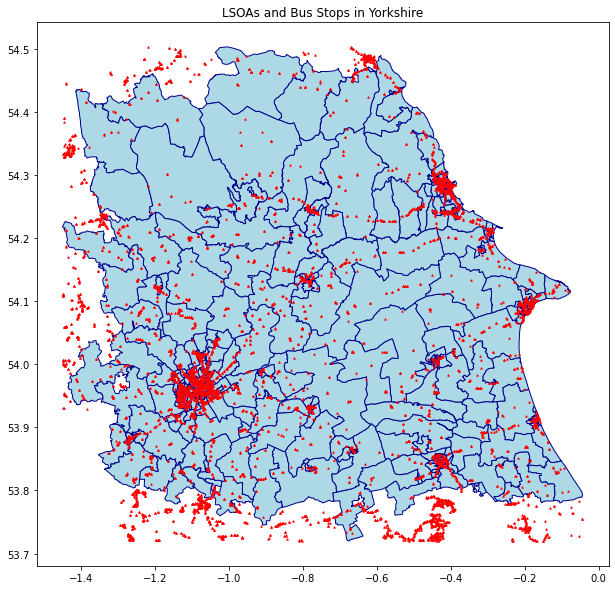

In [6]:
ax1 = areas.plot(facecolor='lightblue', edgecolor='darkblue', figsize=(15, 10))    # the LSOA polygons
ax2 = stops.plot(ax=ax1, color='red', marker='^', markersize=2.0)                  # the stops, using the same plot
ax3 = ax1.set(title='LSOAs and Bus Stops in Yorkshire')                            # add a title

Reassuringly, the population centres of York (bottom left), Bridlington (middle right), and Scarborough (upper right) stand out.  Looking more closely at the rural areas, we can see how the bus stops string out along what we can presume are major roads.

## Finding the density of stops
Now we have the data in, we can start to analyse further.  Today I would like to join together the two datasets we have, in order to count how many bus stops are accessible from each LSOA.

Usually in a data analysis task of this nature, I would be looking for a key on which to join the two data frames together.  But in this kind of geographic analysis, it's a spatial join: matching the two sets of data whenever one of the points lies within, or near, one of the polygons.  Fortunately, geopandas takes care of most of the heavy lifting with the [``sjoin``](https://geopandas.org/reference/geopandas.sjoin.html) (i.e. spatial join) method.

### Looking outside the box
Before I can employ the ``sjoin``, I must remember that I don't want to match bus stops only when they lie within an area, but also if they are near enough to an area to be considered accessible.  Without getting into the complications of roads, foot paths etc. I shall make the rough assumption that an point is 'accessible' if it lies within 1km of the area.

We can use the geopandas [``buffer``](https://geopandas.org/geometric_manipulations.html#GeoSeries.buffer) method to expand each polygon area by a fixed distance beyond its orginal border, but first we must reproject our geometric co-ordinates.

As I mentioned above, we have obtained and processed the data so far using the spherical concepts of latitude and longitude.  The libraries we're using, however, calculate distance in a Euclidean manner, using our good old friend Pythagoras's theorem.  This is not a big problem if our analysis is constrained to the UK, since we can use "eastings and northings" as coordinates, which project the UK onto a cartesian grid, with distances measured in metres.  These units may be already familiar from the markings on an Ordnance Survey map!  The standardised name for this system is [EPSG:27700](https://epsg.io/27700).

Let's start by putting this into practice on one example area.

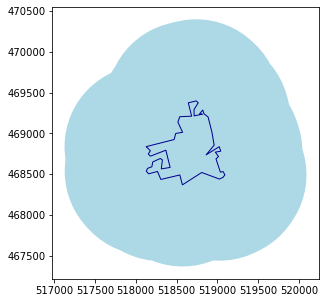

In [7]:
example = areas.loc[['E01012940']].to_crs('EPSG:27700')                  # pick an example, and transform co-ordinates
ax1 = example.buffer(1000).plot(facecolor='lightblue', figsize=(5, 5))   # fill the area expanded by 1000 metres
ax2 = example.plot(facecolor='none', edgecolor='darkblue', ax=ax1)       # add the original boundary line to the same plot

We can clearly see the original area surrounded by its expanded, or buffered, extent at 1km away.  Notice the axes and now labelled with the units in eastings/northings, just like an OS map.

### Putting it all together
We're now ready to combine the two datasets with a spatial join.  We mustn't forget to reproject the points as well as the areas, or we would not be comparing like with like.  We'll summarize the results by counting and plotting the number of matched points per area.

In [8]:
buffers = areas.set_geometry(areas.to_crs('EPSG:27700').buffer(1000)) # new GeoDataFrame with expanded areas
joined = geopandas.sjoin(buffers, stops.to_crs('EPSG:27700'))         # spatial join
counts = joined.index.value_counts().rename('stopsPerLSOA')           # count the number of resulting rows per LSOA

To illustrate the results, I have plotted the stop count for each LSOA to show the variation in bus stop density, firstly as a bar and secondly as a shaded map area.  You can see quite clearly the concentration of bus stops that lie close to the City of York in the bottom-left quadrant.

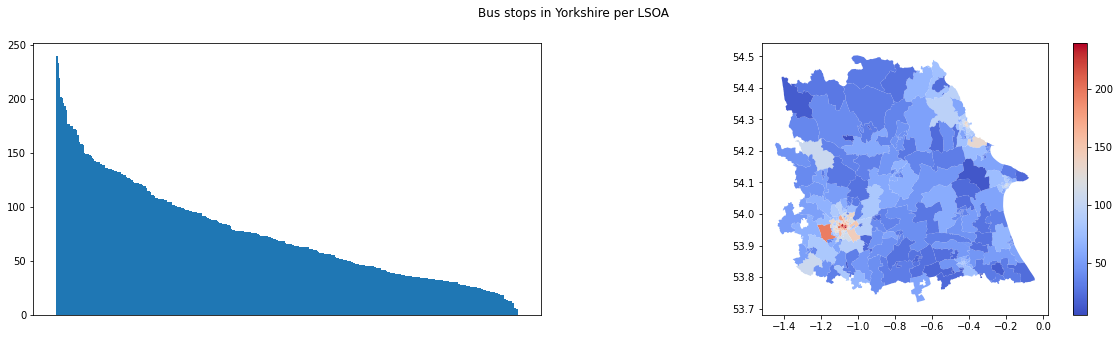

In [9]:
# set up a plot area
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(20,5))  

# bar chart, no need for x-axis
axes[0].bar(counts.index, counts, width=1)
axes[0].get_xaxis().set_visible(False)

# shaded map aka choropleth
counts_areas = geopandas.GeoDataFrame(counts, geometry=areas.geometry)      # new GeoDataFrame combining count and polygon
counts_areas.plot('stopsPerLSOA', cmap='coolwarm', legend=True, ax=axes[1]) # make a shaded map
text = fig.suptitle('Bus stops in Yorkshire per LSOA')

## Conclusion
In my blog today I have aimed to provide some examples of working on geospatial data with GeoPandas, including
* data import and cleansing
* understanding and transforming co-ordinate systems
* geometric operations such as ``clip`` and ``buffer``
* spatial joins.

Beyond the technical walkthrough, along the way I've shown a first step of insight into two openly-available datasets concerning public transport in the UK.  Although at first glance these might seem of interest only to nerdy enthusiasts, the maps produced hint at the wide variation in accessibility of public transport, particularly in rural areas of the UK.  As we work together to level-up and rebuild local economies, not least in the light of the COVID-19 epidemic, this provides food for thought on the barriers faced by many people up and down the land.  In the short-term these barriers can prevent access to assistance, including food aid, but above all can be part of structural challenges to skills and employment.

I'm looking forward to engaging more with these important areas in my time here at Bays Consulting.  For now, I hope this is useful for any data scientists looking to take first steps in geospatial analysis.